# About parameters

In [1]:
import torch

batch_size = 256
print(f"PyTorch version: {torch.__version__}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.12.1+cu113
cuda


# Load MNIST dataset and show first 20 images

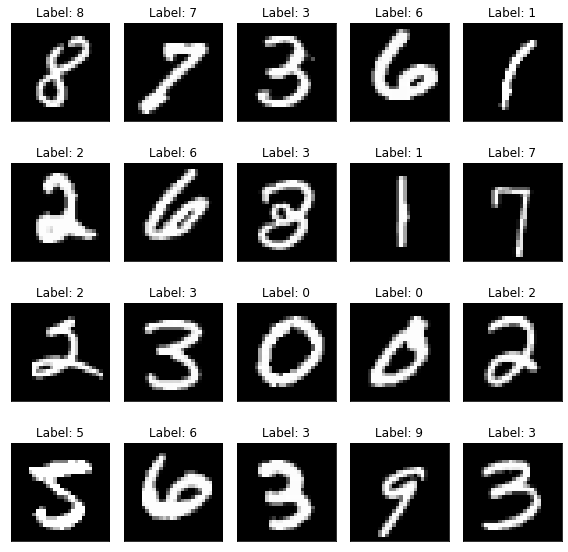

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST

train_path = "D:/Graduate Class/implement practice/PyTorch/dataset/MNIST/train"
test_path = "D:/Graduate Class/implement practice/PyTorch/dataset/MNIST/test"

# if you don't have MNIST dataset, assign download to True
train_ds = MNIST(train_path, train=True, download=False)
test_ds = MNIST(train_path, train=False, download=False)

#####################################
# 1. show first 20 images
# 2. axs.flatten: will flatten the 4*5 subplot array(把4*5的子圖矩陣攤平, 每次送入一個子圖位置)
# 3. if want to show image by imshow() of matplotlib, must convert numpy OR PIL
#####################################
fig, axs = plt.subplots(4, 5, figsize=(8, 8))
for ax in axs.flatten():
    img, lbl = random.choice(train_ds)
    ax.imshow(np.array(img), cmap="gist_gray")
    ax.set_title(f"Label: {lbl}")
    ax.set_xticks([]) # conceal x-axis
    ax.set_yticks([]) # conceal y-axis

plt.tight_layout()

# Dataloader and split dataset
1. split 20% data as validation set
2. split data by random_split, like train_test_split in scikit-learn
3. reference: https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# convert into tensor
train_ds.transforms = transforms.ToTensor()
test_ds.transforms = transforms.ToTensor()

#################################
# 1. random_split data
# 2. in old version, random_split must input integer length, whose sum must equal dataset
# 3. however, in new version, random_split also can input fracton
#################################
length = len(train_ds)
lower, upper = int(length*0.8), int(length*0.2)
train_data, val_data = random_split(train_ds, [lower, upper])

# dataloader
train_dl = DataLoader(train_data, batch_size=batch_size)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=True)


# Define noise function
1. about randn_like: https://pytorch.org/docs/stable/generated/torch.randn_like
2. about torch.clip: https://pytorch.org/docs/stable/generated/torch.clamp.html#torch.clamp

In [8]:
def add_noise(inputs, noise_factor=0.3):
    noise = inputs + randn_like(inputs) * noise_factor # add noise on input image
    noise = torch.clip(noise, 0., 1.) # set pixel range between 0 and 1
    return noise


# Define Variational AE

In [28]:
import torch.nn as nn

# encoder
class Encoder(nn.Module):
    def __init__(self, encoder_output_dim):
        super().__init__()
        
        # convolution
        self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),   # size = [8, 16, 16]
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),  # size = [16, 8, 8]
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0), # size = [32, 3, 3]
        nn.ReLU(True)
        )
        
        # flatten
        self.flatten = nn.Flatten(start_dim=1) # flatten for first dimension i.e. batch
        
        ###################################################
        #self.fc = nn.Linear(32*3*3, 128) # this  fully connect layer also can omit
        ###################################################
        
        ###################################################
        # outputs are mean and variation
        # if just want to  write autoencoder, delete under code and modify forward function
        self.mean = nn.Linear(32*3*3, encoder_output_dim)
        self.var = nn.Linear(32*3*3, encoder_output_dim)
        ###################################################
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        mean = self.mean(x)
        var = self.var(x)
        
        return mean, var

# decoder
class Decoder(nn.Module):
    def __init__(self, decoder_input_dim):
        super().__init__()
        
        # unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        # decoder
        self.decoder = nn.Sequential(
        nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.unflatten(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)
        
        return x
        

## Define sampleer function(抽樣函數)

In [45]:
def sampler(mean, var):
    std = torch.exp(var/2)
    eps = torch.randn_like(std) # sampler from normal distribution N(0, 1)
    return mean + std * eps


# Loss function and optimizer
1. use KL divergence as loss function

In [44]:
import torch.nn.functional as F

# KL divergence
def loss_fn(out, imgs, mean, var):
    kl_divergence = 0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())
    return F.binary_cross_entropy(out, imgs, size_average=False) - kl_divergence

lr= 0.001 # Learning rate

encoder = Encoder(128)
decoder = Decoder(128)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr)

# Define train and test function

In [42]:
# train
def train_epoch_den(encoder, decoder, dataloader, criterion, optimizer, noise_factor=0.3):
    
    # training phase
    encoder.train()
    decoder.train()
    train_loss = []
    
    # start training
    for image_batch, _ in dataloader:
        # add noise
        image_noisy = add_noise(image_batch,noise_factor)
        image_noisy = image_noisy.to(device)
        
        # encoder
        mean, rar = encoder(image_noisy)
        z_code = resample(mean, var)
        
        # decoder
        output = decoder(z_code)
        
        # loss
        loss = criterion(output, image_noisy, mean, var)

        # back propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

# test
def test_epoch_den(encoder, decoder, dataloader, criterion, noise_factor=0.3):
    
    # evaluating phase
    encoder.eval()
    decoder.eval()
    val_loss=0.0
    
    with torch.no_grad(): # No need to track the gradients
        conc_out = []
        conc_label = []
        
        for image_batch, _ in dataloader:
            
            # add noisy
            image_noisy = add_noise(image_batch,noise_factor)
            image_noisy = image_noisy.to(device)
            
            # encoder
            mean, var = encoder(image_noisy)
            z_code = resample(mean, var)
            
            # decoder
            output = decoder(z_code)
            
            # save output into conc_out
            conc_out.append(output.cpu())
            conc_label.append(image_batch.cpu())
            val_loss +=  loss_fn(output.cpu(), image_batch.cpu(), mean, var)
        
        # concact
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        
        # validation loss
    return val_loss.data


# Visualize

In [46]:
import matplotlib.pyplot as plt

def plot_ae_output(epoch, encoder, decoder, n=5, noise_factor=0.3):
    plt.figure(figsize=(10, 4.5))
    
    for i in range(n): # reveal first n number
        ax = plt.subplot(3, n, i+1)
        img = test_ds[i][0].unsqueeze(0) # shape: [C, H, W] -> [Batch, C, H, W]
        
        img_noisy = add_noisy(img, noise_factor)
        img_noisy = img_noisy.to(device)
        
        encoder.eval()
        decoder.eval()
        
        with torch.no_grad(): # do not need to track gradient descent
            rec_img = decoder(resample(*encoder(img_noisy)))
        
        # show original and noisy image once
        if epoch == 0:
            plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title("Original")
            
            # noisy image
            ax = plt.subplot(3, n, i + 1 + n)
            plt.imshow(img_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n//2:
                ax.set_title("Noisy")
            
        # show reconstruction image
        if epoch == 0:
            ax = plt.subplot(3, n, i + 1 + 2*n)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if i == n // 2:
                ax.set_title("Reconstruction")
        else:
            ax = plt.subplot(3, n, i+1)
            plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9, wspace=0.3, hspace=0.3)
    
    plt.show()


In [47]:
noise_factor = 0.3
num_epochs = 50
history_da={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):
    # print(f'EPOCH {epoch + 1}/{num_epochs}')
    # 训练
    train_loss=train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_loader, 
        loss_fn=loss_fn, 
        optimizer=optim,noise_factor=noise_factor)
    # 验证
    val_loss = test_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        loss_fn=loss_fn,noise_factor=noise_factor)
    # Print Validation loss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)
    print(f'EPOCH {epoch + 1}/{num_epochs} \t 训练损失：{train_loss:.3f}' + 
          f' \t 验证损失： {val_loss:.3f}')
    plot_ae_outputs_den(epoch,encoder,decoder,noise_factor=noise_factor)

NameError: name 'train_loader' is not defined